# Introduction to Bayesian inference with Python's `PyMC` library

In this notebook, we'll be introduced to simple Bayesian models in Python using the library `PyMC`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import aesara

In [2]:
import pymc as pm

In [3]:
aesara.config.compute_test_value = "warn"

## Stochastic / deterministic variables and model objects in PyMC

### Model objects

In [4]:
# We create all of our variables within model objects

with pm.Model() as model: # everything created within context of model object belongs to model now
    lambda_param = pm.Exponential("poisson_param", 1.0) 
    DGP = pm.Poisson("DGP", lambda_param)

In [5]:
# We can look at our variables outside the model context, but they can be defined only inside it 

lambda_param

poisson_param

### Stochastic variables

How to define a stochastic variable: 
``python_var_name = pm.DiscreteUniform("pymc_var_name", 0, 10)``

Make the pymc_var_name descriptive because that's where the posterior distro will be later on!

In [6]:
with pm.Model() as another_model:
    lambda_param = pm.Exponential("poisson_param", 1.0)

In [7]:
# Each variable already has a test value
lambda_param.get_test_value()

# test_value is the starting point for sampling in the model if no other initial value is set. 
# It doesn't change the sampling. 

array(1.09159665)

In [8]:
with pm.Model() as another_normal:
    normal = pm.Normal('normal', mu=0, sigma=1)

In [9]:
# starting value
normal.eval()

array(0.27210082)

In [10]:
# draw five samples from the normal variable
pm.draw(normal, 5)

array([ 0.4370534 ,  0.59073402, -0.00739392,  0.55921349, -0.57130893])

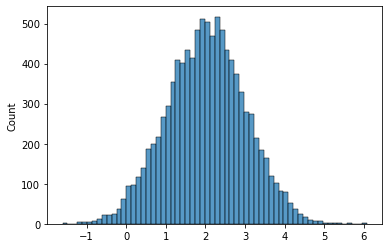

In [11]:
normal_draws = pm.Normal.dist(mu=2, sigma=1, size=10000)
sns.histplot(normal_draws.eval());

### Deterministic variables

Deterministic variables are ones whose values are fixed. They may inherit probabilistic values from parent variables, but their own values are fixed based on the values they inherit.

In [12]:
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    
new_deterministic_variable = lambda_1 + lambda_2

In [13]:
new_deterministic_variable.eval()

array(1.03425459)

In [14]:
def subtract(x, y):
    return x - y

with pm.Model() as model: 
    stochastic_1 = pm.Uniform("u1", 1, 2)
    stochastic_2 = pm.Uniform("u2", 0, 1)

    deterministic_1 = pm.Deterministic("delta", subtract(stochastic_1, stochastic_2))

In [15]:
deterministic_1.eval()

array(1.08470707)

### Putting it all together and looking at our distribution

In [16]:
with pm.Model() as model: 
    lambda_param = pm.Exponential("poisson_param", 1.0) 
    DGP = pm.Poisson("DGP", lambda_param)

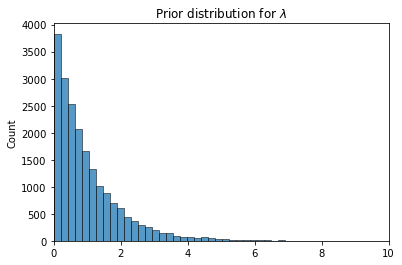

In [17]:
samples = pm.draw(lambda_param, 20000) # this is the stochastic variable we just defined above 

# plot the samples from the exponential distribution
sns.histplot(samples, bins=60)
plt.title("Prior distribution for $\lambda$")
plt.xlim(0, 10);

In [74]:
with pm.Model() as another_normal:
    half_normal = pm.HalfNormal('halfnormal', sigma=1)

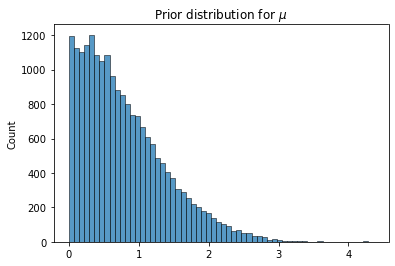

In [75]:
samples_halfnormal = pm.draw(half_normal, 20000) # this is the stochastic variable we just defined above 

# plot the samples from the normal distribution
sns.histplot(samples_halfnormal, bins=60)
plt.title("Prior distribution for $\mu$");

## Fitting a distribution to data

### Priors far from true data, expansive priors

Let's sample some random data from a Normal distribution N(mu=0,sd=.5) and try to fit a distro to it using PyMC. We're trying to see if PyMC can use the samples to guess the parameters of our distribution. 

In [20]:
normal_sample = np.random.normal(0, 1.0, 1000) # mu = 0, sd = 1.0, num. samples = 1000

In [68]:
# Fit a normal distro to our data and see if we can recover our parameters 

with pm.Model() as random_normal:

    # set our priors for the parameters (stochastic nodes)
    sd = pm.Normal('sd', sigma=.5) # SD won't be zero so use half Normal
    mu = pm.Normal('mu', mu=2.0, sigma=1.0)

    pred = pm.Normal('pred', mu=mu, sigma=sd, observed=normal_sample)

In [69]:
print("Type of mu:" , type(mu))
print("\nMean: ", pm.draw(mu, 10000).mean())

Type of mu: <class 'aesara.tensor.var.TensorVariable'>

Mean:  2.0146235723424657


In [70]:
random_normal.observed_RVs

[pred]

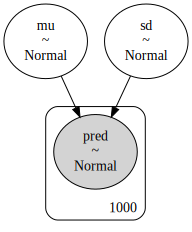

In [71]:
pm.model_to_graphviz(random_normal)

In [72]:
with random_normal:
    trace_normal = pm.sample(500) # MCMC, can use other algos ; sample = # of draws 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 28 seconds.


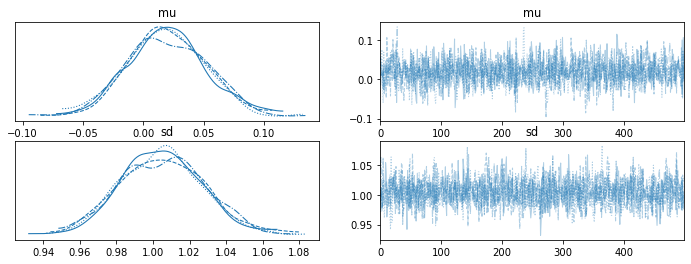

In [73]:
pm.plot_trace(trace_normal, ['mu', 'sd']);

### Priors far from true data, restrictive priors 

In [76]:
normal_sample = np.random.normal(0, 1.0, 1000) # mu = 0, sd = 1.0, num. samples = 1000

In [77]:
# Fit a Normal distro to our data and see if we can recover our parameters 
# This time with restrictive priors far away from the true values

with pm.Model() as random_normal:

    sd = pm.Normal('sd', sigma=.1) 
    mu = pm.Normal('mu', mu=2.0, sigma=.1)

    pred = pm.Normal('pred', mu=mu, sigma=sd, observed=normal_sample)

In [78]:
with random_normal:
    trace_normal = pm.sample(500) # MCMC, can use other algos ; sample = # of draws 
                                   # Will use NUTS (no u-turn sampler), which says we don't have to set # steps 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8801, but should be close to 0.8. Try to increase the number of tuning steps.


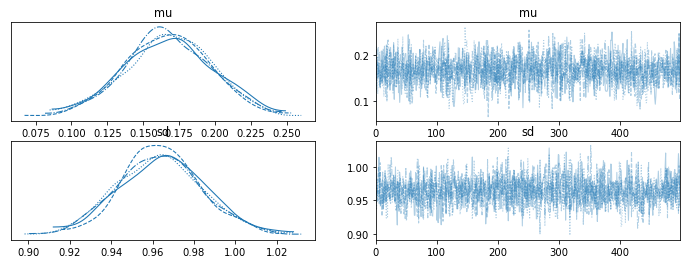

In [80]:
pm.plot_trace(trace_normal, ['mu', 'sd']);

## Linear Regression 

In [81]:
# Let's generate some fake (X,Y) data to fit a linear model

def make_random_OLS_data(num_obs, intercept, beta): 
    X = np.random.normal(1.0, 0.1, num_obs)
    epsilon = np.random.normal(0.0, 0.1, num_obs) # random noise 
    
    # Define our DGP
    y = intercept + (beta*X) + epsilon
    return X, y

In [82]:
X_train, y_train = make_random_OLS_data(num_obs=1000,intercept=1.5,beta=.25)

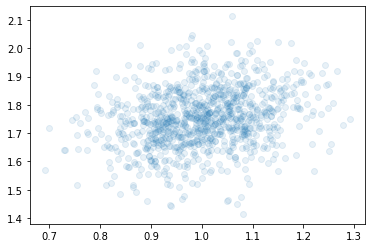

In [83]:
plt.scatter(X_train, y_train, alpha=.1)

In [87]:
with pm.Model() as OLS:

    # Set the priors on the parameters of OLS 
    intercept = pm.Normal('intercept', mu=0.75, sigma=1.0) # actual = 1.5
    beta = pm.Normal('beta', mu=0.0, sigma=1.) # actual = .25
    mu = (beta*X_train) + intercept # equation of a line / OLS equation 
    sd = pm.Normal('sd', sigma=.1) # how restrictive our model is 
    
    y = pm.Normal('y_est', mu=mu, sigma=sd, observed=y_train)

In [88]:
with OLS:
    trace = pm.sample(2500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, sd]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 46 seconds.


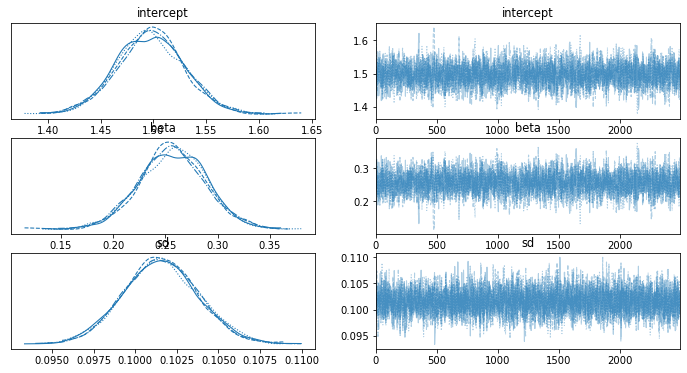

In [89]:
pm.plot_trace(trace, ['intercept', 'beta', 'sd']); 
# intercept: true = 1.5 | prior = .75
# beta: true = .25 | prior = 0.
# true sd = .1

**ppc = posterior predictive check**

In [93]:
# ppc = posterior predictive check 
# Gelman: "simulating replicated data under the fitted model and then comparing these to the observed data"
# Use posterior predictive checks to "look for systematic discrepancies between real and simulated data"

with OLS:
    
    # sample the posterior to fit
    ppc = pm.sample_posterior_predictive(trace) 

In [100]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

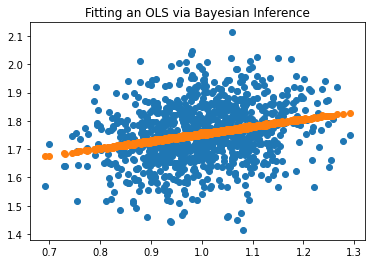

In [132]:
# Use the mean of the 2000 samples per observation to fit our OLS  
y_hat = ppc.posterior_predictive['y_est'][0].values
y_hat_mean = np.reshape(np.mean(y_hat, axis=0), [-1])

plt.scatter(X_train, y_train)
plt.scatter(X_train, y_hat_mean)
plt.title("Fitting an OLS via Bayesian Inference");

## Hierarchical Linear Model

In [155]:
# generate random data 

NUM_GROUPS = 10; 

def generate_hierarchical_data(num_obs_per_group, num_groups, pop_intercept, pop_beta, pop_sd):
    
    group_lvl_params = []
    # numpy arrays most efficient when you create empty ones of the size you'll need at the start
    # since they're assigned contiguous memory 
    Y = np.zeros(shape=(num_groups*num_obs_per_group,1))
    X = np.zeros(shape=(num_groups*num_obs_per_group,1))
    group_id = np.zeros(shape=(num_groups*num_obs_per_group,1))

    for _ in range(num_groups):
        intercept_grp = np.random.normal(pop_intercept, pop_sd)
        beta_grp = np.random.normal(pop_beta, pop_sd)
        group_lvl_params.append([intercept_grp, beta_grp])
        
    print("Group level parameters: \n" , group_lvl_params)
        
    for i, group in enumerate(group_lvl_params):
        indiv_epsilon = np.reshape(np.random.normal(0.0, 0.01, num_obs_per_group), [-1, 1])
        y = group[1]*indiv_epsilon + group[0] # use group parameters and noise (epsilon) to create individual obs

        X[i*num_obs_per_group:i*num_obs_per_group+num_obs_per_group,0] = indiv_epsilon.ravel()
        group_id[i*num_obs_per_group:i*num_obs_per_group+num_obs_per_group,0] = np.ones_like(indiv_epsilon).ravel() * i
        Y[i*num_obs_per_group:i*num_obs_per_group+num_obs_per_group,0] = y.ravel()
    
    return X, Y, group_id

def RMSE(Y,y_hat): 
    return np.sqrt(np.mean((y_hat - Y) ** 2.0))

X, Y, group_id = generate_hierarchical_data(num_obs_per_group=200,num_groups=NUM_GROUPS,pop_intercept=2.3,
                                  pop_beta=4.5,pop_sd=.1)

Group level parameters: 
 [[2.2373559271972137, 4.583006037701708], [2.2726284075680985, 4.496654906286728], [2.301247721959973, 4.50715248427872], [2.281680711286609, 4.496876193919467], [2.306065163027823, 4.459207951504696], [2.1733264088159476, 4.504741517926232], [2.342387378132724, 4.6158868504869], [2.352804811966472, 4.405995522802618], [2.134438333814835, 4.505807215548738], [2.425585571762453, 4.502322545548406]]


### Unpooled

In [156]:
with pm.Model() as FE_unpooled:

    intercept = pm.Normal('intercept', mu=1, sigma=.5, shape=NUM_GROUPS)
    beta = pm.Normal('beta', mu=2, sigma=.5, shape=NUM_GROUPS)
    mu = (beta[group_id.astype(int)] * X) + intercept[group_id.astype(int)]
    
    y = pm.Normal('y', mu, observed=Y)

In [162]:
with FE_unpooled:
    unpooled_trace = pm.sample(2000, tune=2000) # tune will use steps but discrad them 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 39 seconds.


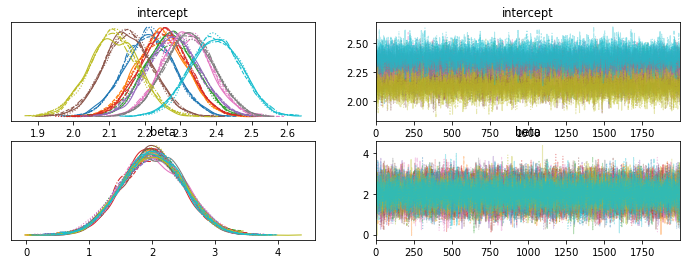

In [163]:
pm.plot_trace(unpooled_trace, ['intercept', 'beta']);

In [164]:
#### RMSE of unpooled 
unpooled_sample = pm.sample_posterior_predictive(unpooled_trace, model=FE_unpooled)

In [165]:
y_hat_unpooled = np.mean(unpooled_sample.posterior_predictive['y'][0], axis=1)

In [166]:
unpooled_RMSE = RMSE(Y,y_hat_unpooled.values)

print("RMSE of unpooled: ", unpooled_RMSE)

RMSE of unpooled:  0.0995501497227444


### Hierarchical 

In [167]:
with pm.Model() as RE_hierarchical:

    pop_intercept = pm.Normal('group_intercept', 1, sigma=5., shape=1)
    pop_intercept_sigma = pm.Normal('group_intercept_sigma', sigma=.5)
    pop_beta = pm.Normal('group_beta', 4, sigma=5., shape=1)
    pop_beta_sigma = pm.Normal('group_beta_sigma', sigma=.5)
    
    intercept = pm.Normal('intercept', mu=pop_intercept, sigma=abs(pop_intercept_sigma), shape=NUM_GROUPS)
    beta = pm.Normal('beta', mu=pop_beta, sigma=abs(pop_beta_sigma), shape=NUM_GROUPS)
    mu = (beta[group_id.astype(int)] * X) + intercept[group_id.astype(int)]
    
    y = pm.Normal('y', mu, observed=Y)

In [175]:
with RE_hierarchical:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_intercept, group_intercept_sigma, group_beta, group_beta_sigma, intercept, beta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 8342 seconds.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.829, but should be close to 0.95. Try to increase the number of tuning steps.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8702, but should be close to 0.95. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.


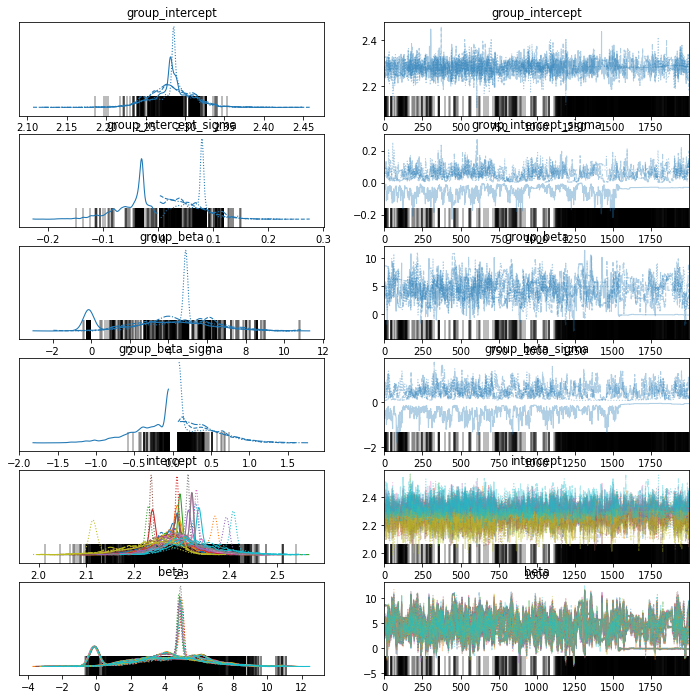

In [173]:
pm.plot_trace(hierarchical_trace, ['group_intercept', 'group_intercept_sigma',
                     'group_beta', 'group_beta_sigma', 'intercept', 'beta']);

In [174]:
#### RMSE of hierarchical
hierarchical_sample = pm.sample_posterior_predictive(hierarchical_trace, model=RE_hierarchical)
y_hat_hierarchical = np.mean(hierarchical_sample.posterior_predictive['y'][0], axis=1)

hierarchical_RMSE = RMSE(Y,y_hat_hierarchical.values)

print("RMSE of unpooled: ", unpooled_RMSE)
print("RMSE of pooled: ", hierarchical_RMSE) # pulls outliers towards the population parameters 

RMSE of unpooled:  0.0995501497227444
RMSE of pooled:  0.09807589924683392
